# Basic canonical sampling recap

Consider a system of $N$ particles in $d$ dimensions with positions $\{\vec{r}_j\}$ and momenta $\{\vec{p}_j\}$ that interacts via some Hamiltonian $\mathcal{H}(\{\vec{r}_j\}) = U(\{\vec{r}_j\}) + K(\{\vec{p}_j\})$. Here $U$ is the potential energy of the system and $K$ the kinetic energy. The positions and momenta collectively define a _microstate_ of the system.

We generally don't bother worrying about sampling momentum coordinates and the kinetic energy $K$ since any contribution those make to quantities of interest can be calculated analytically provided we're at equilibrium. Hence I'll just refer to $U$ as "the energy" in what follows. 

We model the "rest of the universe" by having this system in contact with a heat bath, i.e. a reservoir of energy at constant temperature $T$. Ability to exchange energy with the heath bath leads to thermal equilibriun in which the system visits configurations with probability:

$$ P(\{\vec{r}_j\}) = \frac{ \exp{[-\beta U(\{\vec{r}_j\} )]} }{Z} $$

where $\beta = 1/k_{B}T$ (we'll set $k_B=1$) and $Z$ is the canonical partition function,

$$ Z(N,T) = \int \exp{[-\beta U(\{\vec{r}_j\} )]} \,d\vec{r}^N $$

which in general can't be evaluated directly if $d\times N$ is more than a few degrees of freedom. 

At equilibrium this distribution is stationary, and obeys detailed balance. Labelling two microstates (i.e. sets of particle positions) as $A$ and $B$, the detailed balance criterion requires:

$$ P(A) P(A\rightarrow B) = P(B) P(B \rightarrow A) $$

We then seperate the transition probabilities into the probability of generating a trial move from one microstate to another $P_\textrm{att}$, and the probability of accepting that move $P_\textrm{acc}$ giving

$$ P(A) P_\textrm{att}(A\rightarrow B) P_\textrm{acc}(A\rightarrow B)  = P(B) P_\textrm{att}(B\rightarrow A) P_\textrm{acc}(B\rightarrow A) $$

Provided that we generate trial moves such that $P_\textrm{att}(B\rightarrow A) = P_\textrm{att}(A\rightarrow B)$ then *one* choice of $P_\textrm{acc}$ which satisfies the detailed balance criterion is the Metropolis acceptance rule;


$$P_\textrm{acc} = \min{[\exp{(-\beta \Delta U}),1]} $$

where $\Delta U$ is the change in energy on making the trial move.

We can therefore easily implement a Markov Chain MC procedure to sample the distribution of microstates that are relevant at a particular temperature and use these to compute various physical quantities which depend on ensemble averages (expectations) and variances of quantities that depend on the microstate.

Failing to generate forward and reverse moves with equal probability is a common error which has led to some (many) embarassing errors in the literature. Note also that one can sacrifice this condition provided that $P_{\textrm{acc}}$ is modified accordingly. See configurational bias Monte Carlo methods like force biased MC and Rosenbluth sampling that we won't get into today. 

## Demonstration on a simple bead and spring "polymer" model

Energy is defined by "springs" connecting consecutive beads on the chain, and Van-der-Waals interactions between all non-consecutive beads. See `polymer.py` for details (needs some tidying up and commenting).


### Import packages and create some plotting functions

In [17]:
# Import all the things
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt
%matplotlib ipympl

In [18]:
# Functions for plotting the configuration of the chain
import matplotlib.lines as mlines

def create_chainplot(inchain):
    """Creates figure and draws a polymer config in 2D

    Parameters:
    inchain (polymer): polymer object to plot

    Returns:
    fix, ax : matplotlib figure and axes

    """
    
    fig, ax = plt.subplots()
    fig, ax = draw_chains(fig, ax, inchain)

    #fig.canvas.draw()
    #fig.canvas.flush_events()
    
    return fig, ax

def update_chainplot(fig, ax, inchain):
    """Updates the provided figure and axes with new polymer config

    Parameters:
    fix, ax : matplotlib figure and axes
    inchain (polymer): polymer object to plot
    
    """

    # Clear current axes
    ax.cla() 
    draw_chains(fig, ax, inchain)

    # Update for replotting during animation
    fig.canvas.draw()
    fig.canvas.flush_events()

    return fig, ax

def draw_chains(fig, ax, inchain):
    """Draws a polymer object on the provided figure and axes

    Parameters:
    fix, ax : matplotlib figure and axes
    inchain (polymer): polymer object to plot
    
    """
    
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(-7, 7),ylim=(-7, 7))
    
    xpoints = chain.rpos[:,0]
    ypoints = chain.rpos[:,1]
    line, = ax.plot([], [], marker='o', markersize=10, linewidth=3, markeredgewidth=2, markeredgecolor='black')
    line.set_data(xpoints, ypoints)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Current polymer configuration")
    
    return fig, ax

### Define and visualise the polymer chain

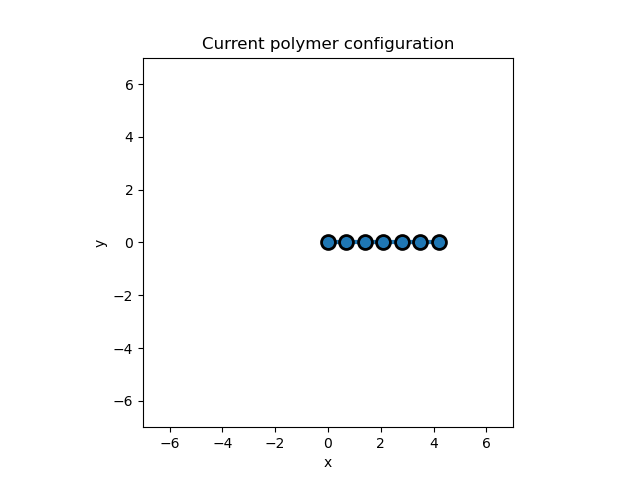

In [19]:
# Create polymer chain
Ndims = 2 ; Nbeads = 7
chain = polymer(Ndims, Nbeads)

# Define bins to be used for plotting (N.B. this assumes I know the energy range I care about in advance!)
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Visualise the initial state of the chain
fig, ax = create_chainplot(chain)
plt.show()

### Function to implement MCMC sampling on the polymer

In [20]:
def run_mcmc_sweeps(chain, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """Performs MCMC on the provided chains for a number of "sweeps" where one sweep is on average
       an attempt to move each mobile particle once. 

    Parameters:
    chain       : polymer object to sample configurations of
    Nsweeps     : number of sweeps to perform
    max_disp    : maximum trial displacement (distance)
    temperature : temperature of heat bath the polyer is coupled to
    sample_int  : interval at which to record samples of energy and end-to-end distance 

    Returns:
    chain       : final state of the polymer
    samples     : list of tuples ( energy, end-to-end distance) of recorded samples
    ratio       : fraction of moves that were accepted

   """

    beta = 1.0/temperature # Store inverse temperature

    samples = [] # Initialise samples for the current set of sweeps
    acount  = 0  # Number of accepted moves

    # Each sweep is one trial per bead on average
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads)

        # Generate random displacement
        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        # Make trial move and compute energy change - note we only compute the terms 
        # in the energy which depend on ibead. See polymer.py
        old_local_energy = chain.local_energy(ibead)
        chain.rpos[ibead] = chain.rpos[ibead] + disp
        new_local_energy = chain.local_energy(ibead)
        diff_energy = new_local_energy - old_local_energy

        # Accept or reject move
        if np.random.sample() < m.exp(-diff_energy*beta):
            acount = acount + 1 # Accepted - increment counter
        else:
            # Restore original chain position 
            chain.rpos[ibead] = chain.rpos[ibead] - disp

        # Sample energy and end-to-end distance every sample_int sweeps
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

    ratio = acount/(Nsweeps*(chain.Nbeads-1)) 
    
    # Return current chain, list of samples and acceptance ratio
    return chain, samples, ratio

### Run the above Nframes times to generate a set of samples at equilibrium

Note the lowest energy hexagon like configuration(s) and extended more linear configurations.


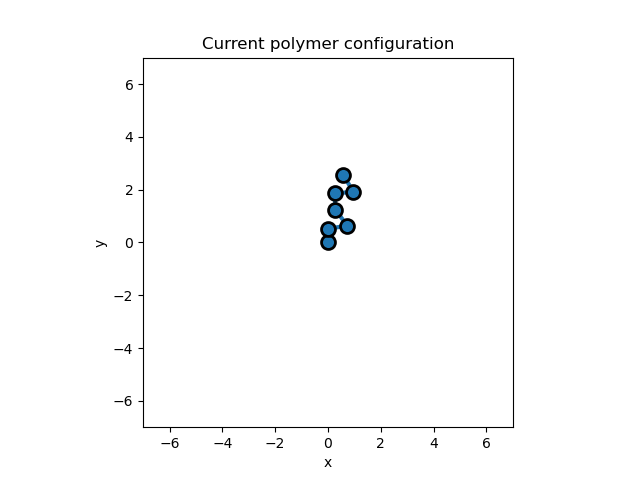

IntProgress(value=0, max=200)

In [26]:
from ipywidgets import IntProgress
from IPython.display import display

temp = 0.4       # Temperature at which to sample
Nframes = 200    # Number of frames to run for

# Setup a plot to update during the simulation
fig, ax = create_chainplot(chain)
plt.show()

# I like a progress bar
f = IntProgress(min=0, max=Nframes)
display(f) # display the bar

Simulate and visualise on the above plot as we go. Note the low energy configuration where the chain coils around a central bead. 

In [28]:
%%time 

samples = []   # Initialise list of samples 
f.value = 0    # Initialise progress bar
plt.ion()      # Modify the above plot interactively

# Loop
for iframe in range(Nframes):

    chain, new_samples, ratio = run_mcmc_sweeps(chain, max_disp=0.1, temperature=temp, Nsweeps=500)
    samples += new_samples
    update_chainplot(fig, ax, chain)
    f.value +=1  # Increment progress bar

plt.ioff() # Done modifying the plot

print("Accepted ",round(ratio*100,2),"% of trial moves during final set of sweeps")

# Save samples to file
filename = "data/mcmc_N"+str(Nbeads)+"_d"+str(Ndims)+"_T{:1.3}".format(temp)+"_Nf"+str(Nframes)+".npy"
np.save(filename,np.asarray(samples))
print("Written samples to : ",filename)

Accepted  59.77 % of trial moves during final set of sweeps
Written samples to :  data/mcmc_N7_d2_T0.4_Nf200.npy
CPU times: user 25.2 s, sys: 2.21 s, total: 27.4 s
Wall time: 25.9 s


### Plot the samples of energy and end-to-end distance

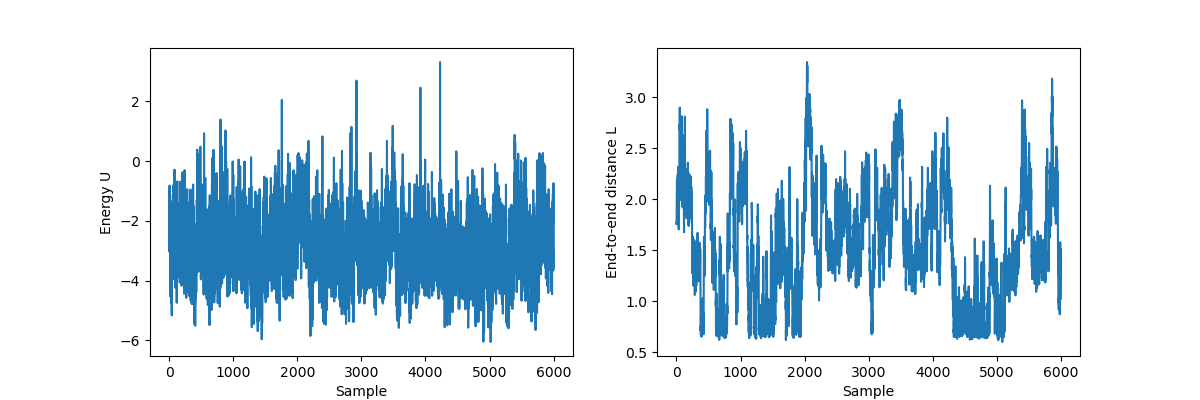

In [29]:
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(energy_samples)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Energy U")
ax2.plot(end2end_samples);
ax2.set_xlabel("Sample")
ax2.set_ylabel("End-to-end distance L");
fig.show()

Some hint via the plot on the right there's two types of configuration, coiled and extended.

### Plot the histogram of energy samples, find mean energy and heat capacity

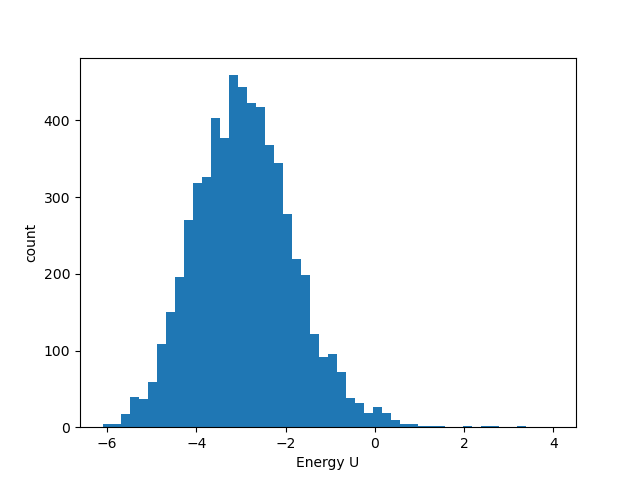

Mean energy <U> :  -2.922
Heat capacity   :  13.678


In [30]:
# Generate plot
fig, ax = plt.subplots()
counts, bins = np.histogram(energy_samples,bins=bin_edges)
plt.hist(bins[:-1], bins, weights=counts)
ax.set_xlabel("Energy U")
ax.set_ylabel("count")
fig.show()

#plt.bar(bins[:-1],counts,width=bin_width,align='edge')
#plt.plot(bins[:-1]+0.5*bin_width,counts)
#counts, bins = np.histogram(end2end_samples,bins=20)
#plt.hist(bins[:-1], bins, weights=counts)

# Mean energy
mean_U = np.mean(energy_samples)
print("Mean energy <U> : ", round(mean_U, 3))

# Heat capacity (depends on variance of energy, and includes an analytic contribution from the kinetic energy)
cv = np.var(energy_samples)/(temp**2) + (Ndims/2)*(Nbeads-1)
print("Heat capacity   : ", round(cv, 3))

### Use some existing data from earlier (and longer runs) to extract trends with temperature

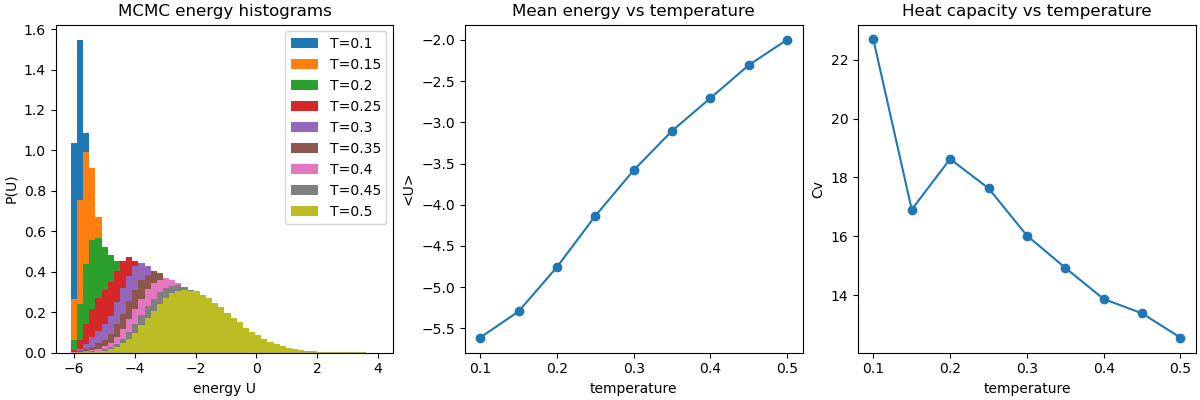

In [31]:
# Get results from runs I did earler from file

# Rough data at same quality as above
#temperatures = np.arange(0.1, 0.6, 0.1)
#run_length = 1000

# Better data from longer independent runs on a "taskfarm" cluster
temperatures = np.arange(0.1, 0.525, 0.05)
run_length = 50000

# Setup plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1.set_xlabel('energy U')
ax1.set_ylabel('P(U)')
ax1.set_title("MCMC energy histograms")

ax2.set_xlabel('temperature')
ax2.set_ylabel('<U>')
ax2.set_title('Mean energy vs temperature')  

ax3.set_xlabel('temperature')
ax3.set_ylabel('Cv')
ax3.set_title('Heat capacity vs temperature') 

# Initialise arrays 
mean_energies   = np.zeros(len(temperatures))
mean_errors     = np.zeros(len(temperatures))
heat_caps       = np.zeros(len(temperatures))
#heat_caps2      = np.zeros(len(temperatures))

# Loop over temperatures of interest
for itemp, temperature in enumerate(temperatures):
    
    # Load data
    filename = "data/mcmc_N7_d2_T{:1.3}_Nf{}.npy".format(temperature,run_length)
    samples = np.load(filename).tolist()
    energy_samples  = [ sample[0] for sample in samples ]

    # Create histogram
    counts, bins = np.histogram(energy_samples, bins=bin_edges, density=True)
    strlabel = "T={:1.2}".format(temperature)
    ax1.bar(bins[:-1], counts, width=bin_width, align='edge', label=strlabel)

    # Compute mean energy and heat capacity
    
    # If wanting to interpret the error bars computed here as uncertainties in the estimates
    # of mean energy we should sub-sample at an interval greater than the autocorrelation
    # time of our samples, and also discard the "burn in" or equilibration period.     
    #energy_samples  = [ sample[0] for sample in samples[1000:6000:100] ] # Drop equilibration period and subsample

    mean_energies[itemp] = np.mean(energy_samples)
    mean_errors[itemp] = np.std(energy_samples)/m.sqrt(len(energy_samples))

    # Compute heat capacity using the raw samples
    heat_caps[itemp] = np.var(energy_samples)/(temperature**2) + (Ndims/2)*(Nbeads-1)

    # Compute heat capacity from the discretised (binned) data
    #msq_dev = np.zeros(len(bin_edges)-1)
    #for ibin, edge in enumerate(bin_edges[:-1]):
    #    bin_energy = edge + 0.5*bin_width
    #    msq_dev[ibin] = (bin_energy - mean_energies[itemp])**2
        
    #heat_caps2[itemp] = np.dot(msq_dev, counts)*bin_width/(temperature**2) + (Ndims/2)*(Nbeads-1)

# Complete plots using data computed above
ax1.legend()
ax2.errorbar(temperatures, mean_energies,yerr=mean_errors, fmt='-o')
ax3.plot(temperatures, heat_caps, '-o', label='samples')
#ax3.plot(temperatures, heat_caps2, '-o', label='histogram')
#ax3.legend()
 
plt.show()

### Notes on the results

1. The spike in heat capacity at $T=0.1$ here is completely spurious. It shouldn't be there and is the result of a non-ergodic trap. There are multiple configurations of the coiled polymer, but at $T=0.1$ the probability of sampling transitions between them (which go via high energy states very improbable at low $T$) within a finite-length simulation is negligible.

2. This is very inefficient as we've run multiple independent simulations that produce overlapping energy histograms. Each energy bin (or _macrostate_) contains microstates that are being wastefully sampled multiple times independently. Ideally we'd want each sample of a configuration to contribution to our statistics at all temperatures were it is relevant without having need to resample it.
(Parallel tempering might be useful here, but I'm going a different route today).

4. We can so far only create data points for plots against temperature if we've done a simulation at that temperature, not at any temperature in between. 

See `MUCA.ipynb` for the first example of a method which does better.

### Histogram reweighting and sample reweighting...

Can be used here to produce data at temperatures _close to_ those at which we have explicit samples provided all energies relevant at the temperature of interest are sampled within a simulation we've already got. Limited utility especially as $N$ becomes large and the histograms at each temperature become less broad...

Defer demonstration of reweighting until the next notebook where we'll have samples over the full energy range from a single simulation.


## Bits and bobs used for debugging below

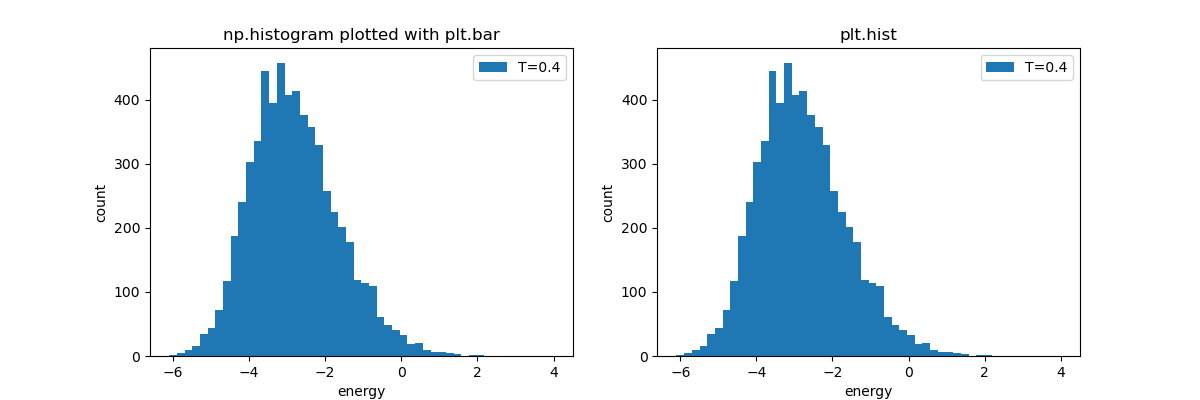

In [10]:
# Sanity checking two equivalent ways of generating the same histogram
samples = np.load("data/mcmc_N7_d2_T0.4_Nf1000.npy").tolist()
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

# Use np.histogram and then plt.bar with the output
counts, bins = np.histogram(energy_samples, bins=bin_edges)
ax1.bar(bins[:-1], counts, width=bin_width, align='edge', label='T=0.4')
ax1.set_xlabel('energy')
ax1.set_ylabel('count')
ax1.set_title("np.histogram plotted with plt.bar")
ax1.legend()

# Use plt.hist
n, bins, patches = ax2.hist(bins[:-1], bins, weights=counts, label='T=0.4')
ax2.set_xlabel('energy')
ax2.set_ylabel('count')
ax2.set_title("plt.hist")
ax2.legend()
plt.show()